# Code topology optimization top88

Robin Grapin

In [16]:
using SparseArrays
using LinearAlgebra
using Plots
using Statistics
using SuiteSparse
E0 = 1;
Emin = 1e-9;
nu = 0.3;

In [18]:
function top88(nelx,nely,volfrac,penal,rmin,ft)
        
    A11 = [12  3 -6 -3;  3 12  3  0; -6  3 12 -3; -3  0 -3 12]
    A12 = [-6 -3  0  3; -3 -6 -3 -6;  0 -3 -6  3;  3 -6  3 -6]
    B11 = [-4  3 -2  9;  3 -4 -9  4; -2 -9 -4 -3;  9  4 -3 -4]
    B12 = [ 2 -3  4 -9; -3  2  9 -2;  4  9  2  3; -9 -2  3  2]
    KE = 1/(1-nu^2)/24*([A11 A12;A12' A11]+nu*[B11 B12;B12' B11])

    nodenrs = reshape(1:(1+nelx)*(1+nely),1+nely,1+nelx); #number of the nodes in columns
    edofVec = reshape(2*nodenrs[1:end-1,1:end-1].+1,nelx*nely,1) ;#1st dof of each element (x top left)
    edofMat = zeros(nelx*nely, 8); #every line i contains the 8 dof of the ith element
    noeudsvoisins = [0 1 2*nely.+[2 3 0 1] -2 -1];
    for i = 1:8
        for j = 1:nelx*nely
            edofMat[j,i]= edofVec[j]+ noeudsvoisins[i] ;
        end
    end
        #meshing
    iK = reshape(kron(edofMat,ones(8,1))',64*nelx*nely,1);# line to build  K
    jK = reshape(kron(edofMat,ones(1,8))',64*nelx*nely,1);# columns
    #F = spzeros(2*(nely+1)*(nelx+1),1); F[2,1] = -1; impossible to solve in Julia with F sparse
    F = zeros(2*(nely+1)*(nelx+1),1); F[2,1] = -1; 
    U = zeros(2*(nely+1)*(nelx+1),1);
    fixeddofs = union(1:2:2*(nely+1),[2*(nelx+1)*(nely+1)]);
    alldofs = 1:2*(nely+1)*(nelx+1);
    freedofs = setdiff(alldofs,fixeddofs);
        #filtering is linear + chain's rule -> matricial opration with operator H
    iH = ones(nelx*nely*(2*(convert(Int64,ceil(rmin)-1))+1)^2);#lines H
    jH = ones(size(iH));# columns
    sH = zeros(size(iH));# values
    k = 0;
    for i1 = 1:nelx
        for j1 = 1:nely
            e1 = (i1-1)*nely+j1;
            for i2 = max(i1-(ceil(rmin)-1),1):min(i1+(ceil(rmin)-1),nelx)
                for j2 = max(j1-(ceil(rmin)-1),1):min(j1+(ceil(rmin)-1),nely)
                    e2 = (i2-1)*nely+j2;
                    k = k+1;
                    iH[k] = e1;
                    jH[k] = e2;
                    sH[k] = max(0,rmin-sqrt((i1-i2)^2+(j1-j2)^2));
                end
            end
        end
    end
    H = sparse(iH,jH,sH);# matrix of the Hei
    Hs = [sum(H[i,:]) for i = 1:(size(H)[1])];# sum of the Hei for e fixed -> coeffs used to divide in the filter
        #variables
    x = volfrac*ones(nely,nelx);
    xPhys = x; #new variable for the density filter
    loop = 0;
    change = 1;
    cValues = []
    while change > 0.01
        loop = loop + 1;
        sK = [j*((i+Emin)^penal) for i in ((E0-Emin)*xPhys[:]') for j in KE[:] ];#new values EF
        K = sparse(iK[:],jK[:],sK); K = (K+K')/2;# force to be symmetric
        KK = cholesky(K[freedofs,freedofs]);
        U[freedofs] = KK\F[freedofs];
        
            # analyse, objective function
        edM = [convert(Int64,i) for i in edofMat] ;#to index by int
        mat = (U[edM]*KE).*U[edM];
        ce = reshape([sum(mat[i,:]) for i = 1:(size(mat)[1])],nely,nelx);
        c = sum(sum((Emin*ones(size(xPhys)).+(xPhys.^penal)*(E0-Emin)).*ce));
        push!(cValues,c)
        dc = -penal*(E0-Emin)*xPhys.^(penal-1).*ce;
        dv = ones(nely,nelx);
        
            #filtering
        if ft == 1
            dc[:] = H*(x[:].*dc[:])./Hs./max(1e-3,maximum(x[:]));
        elseif ft == 2
            dc[:] = H*(dc[:]./Hs);
            dv[:] = H*(dv[:]./Hs);
        end
            #Lagrangian multiplicators research, upload of the density x
        l1 = 0; l2 = 1e9; move = 0.2;
        xnew = zeros(nely, nelx);
        while (l2-l1)/(l1+l2) > 1e-3
            lmid = 0.5*(l2+l1);
            RacBe = sqrt.(-dc./dv/lmid) ;
            XB = x.*RacBe ;
            for i = 1:nelx
                for j = 1:nely
                    xji = x[j,i];
                    xnew[j,i]= max(0.001,max(xji-move,min(1,min(xji+move,XB[j,i]))));
                end
            end  
            if ft == 1
                xPhys = xnew;
            elseif ft == 2 # if we chose the density filter
                xPhys[:] = (H*xnew[:])./Hs;
            end
            if sum(xPhys[:]) > volfrac*nelx*nely
                l1 = lmid;
            else 
                l2 = lmid; 
            end
        end
        change = maximum(abs.(x-xnew));
        x = xnew;
        println("loop = ", loop, "Change = ", change ," c = ", c , " densité struct = ", mean(x) )
        if loop == 25
            return heatmap(x), loop, cValues
        end
    end
    return heatmap(x) , loop , cValues
end

top88 (generic function with 1 method)

loop = 1Change = 0.2 c = 836.7175943191559 densité struct = 0.32992474527058707
loop = 2Change = 0.20000000000000007 c = 446.84169209963727 densité struct = 0.3298767846237456
loop = 3Change = 0.20000000000000007 c = 304.5494025198239 densité struct = 0.330046390267495
loop = 4Change = 0.20000000000000007 c = 229.61032257203635 densité struct = 0.3301740752917438
loop = 5Change = 0.20000000000000007 c = 177.1042708925683 densité struct = 0.3300694684378046
loop = 6Change = 0.20000000000000007 c = 141.60759778095732 densité struct = 0.33002376365180597
loop = 7Change = 0.20000000000000007 c = 117.64131573283302 densité struct = 0.33002383498789867
loop = 8Change = 0.20000000000000007 c = 98.93812357275603 densité struct = 0.32999966873948877
loop = 9Change = 0.20000000000000007 c = 88.13484600184596 densité struct = 0.33004449858202645
loop = 10Change = 0.20000000000000007 c = 81.85020545037523 densité struct = 0.3299772534426564
loop = 11Change = 0.20000000000000007 c = 77.857451186732

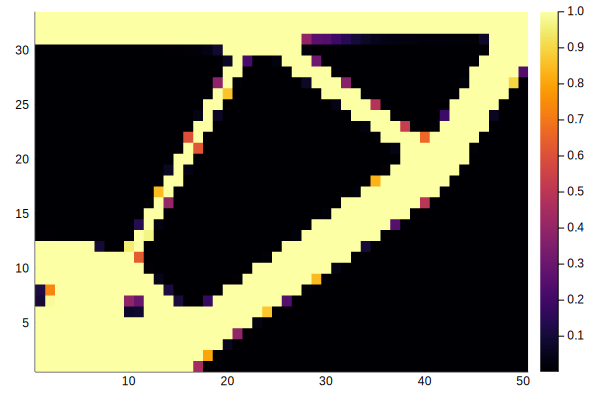

In [14]:
h,l,c = top88(50,33,0.1, 3,2,1);
h #: final mass repartition
#plot(1:l,c,title = "sensity evolution", label = "sensity c") #evolution of c during the process
#xlabel!("iteration")

In [15]:
propo = 0.1:0.1:1

0.0:0.1:1.0

## Original code top88 by Ole Sigmund

In [5]:
"""
%%%% AN 88 LINE TOPOLOGY OPTIMIZATION CODE Nov, 2010 %%%%
function top88(nelx,nely,volfrac,penal,rmin,ft)
%% MATERIAL PROPERTIES
E0 = 1;
Emin = 1e-9;
nu = 0.3;
%% PREPARE FINITE ELEMENT ANALYSIS
A11 = [12  3 -6 -3;  3 12  3  0; -6  3 12 -3; -3  0 -3 12];
A12 = [-6 -3  0  3; -3 -6 -3 -6;  0 -3 -6  3;  3 -6  3 -6];
B11 = [-4  3 -2  9;  3 -4 -9  4; -2 -9 -4 -3;  9  4 -3 -4];
B12 = [ 2 -3  4 -9; -3  2  9 -2;  4  9  2  3; -9 -2  3  2];
KE = 1/(1-nu^2)/24*([A11 A12;A12' A11]+nu*[B11 B12;B12' B11]);
nodenrs = reshape(1:(1+nelx)*(1+nely),1+nely,1+nelx);
edofVec = reshape(2*nodenrs(1:end-1,1:end-1)+1,nelx*nely,1);
edofMat = repmat(edofVec,1,8)+repmat([0 1 2*nely+[2 3 0 1] -2 -1],nelx*nely,1);
iK = reshape(kron(edofMat,ones(8,1))',64*nelx*nely,1);
jK = reshape(kron(edofMat,ones(1,8))',64*nelx*nely,1);
% DEFINE LOADS AND SUPPORTS (HALF MBB-BEAM)
F = sparse(2,1,-1,2*(nely+1)*(nelx+1),1);
U = zeros(2*(nely+1)*(nelx+1),1);
fixeddofs = union([1:2:2*(nely+1)],[2*(nelx+1)*(nely+1)]);
alldofs = [1:2*(nely+1)*(nelx+1)];
freedofs = setdiff(alldofs,fixeddofs);
%% PREPARE FILTER
iH = ones(nelx*nely*(2*(ceil(rmin)-1)+1)^2,1);
jH = ones(size(iH));
sH = zeros(size(iH));
k = 0;
for i1 = 1:nelx
  for j1 = 1:nely
    e1 = (i1-1)*nely+j1;
    for i2 = max(i1-(ceil(rmin)-1),1):min(i1+(ceil(rmin)-1),nelx)
      for j2 = max(j1-(ceil(rmin)-1),1):min(j1+(ceil(rmin)-1),nely)
        e2 = (i2-1)*nely+j2;
        k = k+1;
        iH(k) = e1;
        jH(k) = e2;
        sH(k) = max(0,rmin-sqrt((i1-i2)^2+(j1-j2)^2));
      end
    end
  end
end
H = sparse(iH,jH,sH);
Hs = sum(H,2);
%% INITIALIZE ITERATION
x = repmat(volfrac,nely,nelx);
xPhys = x;
loop = 0;
change = 1;
%% START ITERATION
while change > 0.01
  loop = loop + 1;
  %% FE-ANALYSIS
  sK = reshape(KE(:)*(Emin+xPhys(:)'.^penal*(E0-Emin)),64*nelx*nely,1);
  K = sparse(iK,jK,sK); K = (K+K')/2;
  U(freedofs) = K(freedofs,freedofs)\F(freedofs);
  %% OBJECTIVE FUNCTION AND SENSITIVITY ANALYSIS
  ce = reshape(sum((U(edofMat)*KE).*U(edofMat),2),nely,nelx);
  c = sum(sum((Emin+xPhys.^penal*(E0-Emin)).*ce));
  dc = -penal*(E0-Emin)*xPhys.^(penal-1).*ce;
  dv = ones(nely,nelx);
  %% FILTERING/MODIFICATION OF SENSITIVITIES
  if ft == 1
    dc(:) = H*(x(:).*dc(:))./Hs./max(1e-3,x(:));
  elseif ft == 2
    dc(:) = H*(dc(:)./Hs);
    dv(:) = H*(dv(:)./Hs); %dv est dc filtre
  end
  %% OPTIMALITY CRITERIA UPDATE OF DESIGN VARIABLES AND PHYSICAL DENSITIES
  l1 = 0; l2 = 1e9; move = 0.2;
  while (l2-l1)/(l1+l2) > 1e-3
    lmid = 0.5*(l2+l1);
    xnew = max(0,max(x-move,min(1,min(x+move,x.*sqrt(-dc./dv/lmid)))));
    if ft == 1
      xPhys = xnew;
    elseif ft == 2
      xPhys(:) = (H*xnew(:))./Hs;
    end
    if sum(xPhys(:)) > volfrac*nelx*nely, l1 = lmid; else l2 = lmid; end
  end
  change = max(abs(xnew(:)-x(:)));
  x = xnew;
  %% PRINT RESULTS
  fprintf(' It.:%5i Obj.:%11.4f Vol.:%7.3f ch.:%7.3f\n',loop,c, ... 
    mean(xPhys(:)),change);
  %% PLOT DENSITIES
  colormap(gray); imagesc(1-xPhys); caxis([0 1]); axis equal; axis off; drawnow;
end
%
"""

LoadError: syntax: invalid escape sequence

In [19]:
@time x,l,values = top88(100,100,0.5,3,2,1)

loop = 1Change = 0.2 c = 181.02944558470028 densité struct = 0.49995144886389187
loop = 2Change = 0.20000000000000007 c = 87.70747378137004 densité struct = 0.5001614594571799
loop = 3Change = 0.20000000000000007 c = 51.266856533836275 densité struct = 0.4998727321391105
loop = 4Change = 0.20000000000000007 c = 37.10721162015415 densité struct = 0.5000877840247414
loop = 5Change = 0.20000000000000007 c = 33.47226987144041 densité struct = 0.5000324691873671
loop = 6Change = 0.20000000000000007 c = 31.701271804970467 densité struct = 0.5000380819496312
loop = 7Change = 0.20000000000000007 c = 30.68077904834976 densité struct = 0.4999725989288342
loop = 8Change = 0.20000000000000007 c = 30.056612408090903 densité struct = 0.4999948254123275
loop = 9Change = 0.20000000000000007 c = 29.697007899595246 densité struct = 0.4999901086505678
loop = 10Change = 0.20000000000000007 c = 29.509405391607785 densité struct = 0.4999967663977346
loop = 11Change = 0.20000000000000007 c = 29.3835613987361

(Plot{Plots.GRBackend() n=1}, 25, Any[181.02944558470028, 87.70747378137004, 51.266856533836275, 37.10721162015415, 33.47226987144041, 31.701271804970467, 30.68077904834976, 30.056612408090903, 29.697007899595246, 29.509405391607785  …  29.17646552587081, 29.16804630459116, 29.159652759679492, 29.1514975967792, 29.144847980842343, 29.138851524864197, 29.133919112325113, 29.12907726110656, 29.123976206463112, 29.118662087008154])

In [5]:
values

25-element Array{Any,1}:
 181.02944558470028
  87.70747378137004
  51.266856533836275
  37.10721162015415
  33.47226987144041
  31.701271804970467
  30.68077904834976
  30.056612408090903
  29.697007899595246
  29.509405391607785
  29.38356139873617
  29.292020865461083
  29.242405104392603
  29.20736430960941
  29.187038379599663
  29.17646552587081
  29.16804630459116
  29.159652759679492
  29.1514975967792
  29.144847980842343
  29.138851524864197
  29.133919112325113
  29.12907726110656
  29.123976206463112
  29.118662087008154